In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [2]:

from argparse import ArgumentParser
from collections import defaultdict
from math import ceil, sin
from math import floor

import scipy
import pandas as pd
import numpy as np

import numpy as np
import torch

#import torch_xla
#import torch_xla.core.xla_model as xm
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.autograd.functional import jacobian
from torch.nn.modules.container import T

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib as mpl
from functools import partial

In [3]:
from scipy.interpolate import griddata

In [4]:
from matplotlib.gridspec import GridSpec

Run this notebook with cuda

In [5]:
import wandb

In [ ]:
wandb.login()

True

In [6]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=95ae57a947d480b1607ef4b84cbdd13274d8979337ccde85b89add6cb8a59464
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
device

device(type='cuda')

In [9]:
from pyDOE import lhs

In [129]:
#v = torch.tensor(1.0/torch.pi**2)  # Viscosity coefficient
v = (0.01/torch.pi)  # From Raissi article


hidden_dim = 50
resblocks=2   # 0 when not Resnet


hidden_layers = 0 #



input_dim=2
output_dim=1
lambda_f=1
activation='tanh'
learningRate=0.0001
wd=1e-4      # 1e-5 base
n_epochs=6000
N=2000

N_f=4000
N_u=200
network='ResNet' # MLP Or ResNet

In [130]:

wandb.init(
    # set the wandb project where this run will be logged
    project="Burgesfinal",

    # track hyperparameters and run metadata
    config={
    "Viscosity": v,
    "N_f":N_f,
    "N_u":N_u,
    "learning_rate": learningRate,
    "weight_decay": wd,
    "hidden_layers": hidden_layers,
    "hidden_dim": hidden_dim,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation':activation,
    'lambda': lambda_f,
    'numResblocks': resblocks,
    "epochs": n_epochs,
    'network': network
    }
)

In [12]:
def plot_loss(losses):
    fig, ax = plt.subplots()
    fig.canvas.manager.set_window_title("Loss terms")

    # Extract the loss values from the dictionary
    lossNN = losses["Res"]
    lossBC = losses["BC"]
    lossIC=losses['IC']
    #lossData=losses["Data"]
    # Plot both losses
    ax.plot(lossNN, label='Residual')
    ax.plot(lossBC, label='BC')
    ax.plot(lossIC, label='IC')
    #ax.plot(lossData, label='Data')

    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Neural Network and Equation Losses over Epochs")
    plt.show()


In [13]:
losses = defaultdict(list)

In [14]:
def xavier_init(module):
        for m in module.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)


In [15]:
class SinusActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

In [16]:
# MLP neural network as a function of neurons (hidden_dim), the number of layers and activation function

def construct_network(input_dim, output_dim, hidden_dim, hidden_layers, activation):
    # Activation function mapping
    activations = {
        'swish': nn.SiLU,
        'tanh': nn.Tanh,
        'relu': nn.ReLU,
        'gelu': nn.GELU,
        'softplus': nn.Softplus,
        'sin': SinusActivation
    }

    # Check if activation is valid
    if activation not in activations:
        raise ValueError(f"Invalid activation function. Expected one of: {list(activations.keys())}")

    ActivationFunc = activations[activation]

    # Construct the layers
    layers = [nn.Linear(input_dim, hidden_dim), ActivationFunc()]
    for _ in range(hidden_layers):
        layers.extend([nn.Linear(hidden_dim, hidden_dim), ActivationFunc()])
    layers.append(nn.Linear(hidden_dim, output_dim))
    layers.append(ActivationFunc())  # Activation function for the output layer


    # Create the network
    net = nn.Sequential(*layers).double().to(device)

    xavier_init(net)
    return net

# Example usage:
# net = construct_network(10, 2, 128, 3, 'relu', device='cuda')


In [35]:
# ResNet neural network as a function of neuron, the number of resnet blocks and activation function
class ResidualBlockScalar(nn.Module):
    def __init__(self, features, activation_func):
        super(ResidualBlockScalar, self).__init__()
        self.linear1 = nn.Linear(features, features)
        self.linear2 = nn.Linear(features, features)
        self.activation = activation_func()

    def forward(self, x):
        residual = x
        x = self.activation(self.linear1(x))
        x = self.linear2(x)
        return self.activation(x + residual)

class SimpleResNetScalar(nn.Module):
    def __init__(self, num_classes, features, num_blocks, activation='relu'):
        super(SimpleResNetScalar, self).__init__()
        activations = {
            'swish': nn.SiLU,
            'tanh': nn.Tanh,
            'relu': nn.ReLU,
            'gelu': nn.GELU,
            'softplus': nn.Softplus,
            'sin': SinusActivation  # Assuming SinusActivation is defined elsewhere
        }

        self.linear1 = nn.Linear(2, features)
        self.activation = activations[activation]()
        self.res_blocks = nn.ModuleList([ResidualBlockScalar(features, activations[activation]) for _ in range(num_blocks)])
        self.linear2 = nn.Linear(features, num_classes)
        self.final_activation = activations[activation]()  # Activation function after the final layer

    def forward(self, x):
        x = self.activation(self.linear1(x))
        for block in self.res_blocks:
            x = block(x)
        x = self.linear2(x)
        return self.final_activation(x)  # Apply activation function here

# Example instantiation
#model = SimpleResNetScalar(num_classes=output_dim, features=hidden_dim, num_blocks=resblocks, activation='swish')


In [131]:
# # Model parameters

# Set random seed for reproducibility
torch.manual_seed(54)


x_int = lhs(2, N_f)  # [t; x], both in [0, 1]
x_int=torch.tensor(x_int)
x_int[..., 1] = 2 * (x_int[..., 1] - 0.5)  # shift x to [-1, 1]
u_int = torch.zeros(N_f, 1)
u_train=-torch.exp(-x_int[...,0]) * torch.sin(torch.pi * x_int[...,1])


# Initial conditions
x_ini = torch.rand(N_u, 2)
x_ini[..., 0] = 0  # t = 0
x_ini[..., 1] = 2 * (x_ini[..., 1] - 0.5)  # x, -1 to 1
u_ini = torch.sin(-torch.pi * x_ini[..., 1]).reshape(N_u, 1)


# Boundary conditions
x_bc = torch.rand(N_u, 2)  # t, 0 to 1
x_bc[..., 1] = torch.tensor([-1, 1])[torch.randint(0, 2, (N_u,))]  # -1 or 1
u_bc = torch.zeros(N_u, 1)


# Merge inputs
x_inp = torch.cat([x_int, x_bc, x_ini], dim=0).float()

u_inp = torch.cat([u_int, u_bc, u_ini], dim=0).float()


# Print shapes to verify
print(f"x_inp shape: {x_inp.shape}, u_inp shape: {u_inp.shape}")
x_bc_inp = x_bc
x_ini_inp = x_ini
x_inp = x_int
u_bc_inp = u_bc
u_ini_inp = u_ini
#u_inp = u_int

x_inp = torch.reshape(x_inp,(-1,2));
u_inp = torch.reshape(u_inp,(-1,1));

x_bc_inp = torch.reshape(x_bc_inp,(-1,2));
u_bc_inp = torch.reshape(u_bc_inp,(-1,1));

x_ini_inp = torch.reshape(x_ini_inp,(-1,2));
u_ini_inp = torch.reshape(u_ini_inp,(-1,1));





x_inp shape: torch.Size([4400, 2]), u_inp shape: torch.Size([4400, 1])


In [19]:
data = scipy.io.loadmat('/content/sample_data/burgers_shock.mat')

In [20]:
#data = scipy.io.loadmat('/content/sample_data/burgers_shock.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)


In [21]:
from matplotlib.gridspec import GridSpec

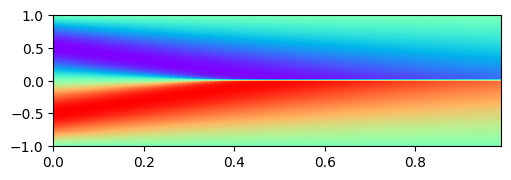

In [22]:
 ####### Row 0: u(t,x) ##################
gs0 = GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')


In [23]:
def data_loss(xint,u_obs):
  u_pred=model(xint.double().to(device))
  #print(u_obs.shape)
  return torch.mean((u_pred.flatten()-u_obs.double().to(device).flatten())**2)

In [24]:
def loss_initial(xinit,uinit):
  # Predictions for initial
  u_ini_pred = model(xinit.double().to(device))
  # Initial loss
  return torch.mean((u_ini_pred.flatten() - uinit.double().to(device).flatten())**2)

In [25]:
def loss_boundary(xbc,ubc):
  # Predictions for boundary conditions
  u_bc_pred = model(xbc.double().to(device))
  # Loss for boundary conditions
  return torch.mean((u_bc_pred.flatten() - ubc.double().to(device).flatten())**2)

In [26]:
def loss_residual(xint):
  # interior points
  # Compute gradients for the Burger's Equation
  xint.requires_grad_(True)
  # Model prediction
  u = model(xint.double().to(device))
  # Gradients of u with respect to x
  u_x = torch.autograd.grad(u, xint, grad_outputs=torch.ones_like(u), create_graph=True)[0]
  # Components of the gradient
  u_t = u_x[:, 0]
  u_x = u_x[:, 1]

  # Second derivative with respect to x
  u_xx = torch.autograd.grad(u_x, xint, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 1]
  # Burger's Equation Residual
  f = u_t.to(device) + (u.flatten() * u_x.to(device)) - (v * u_xx.to(device))
  # Return interior loss
  return torch.mean(f**2)


In [132]:
 # Initialize the model

#model=construct_network(input_dim, output_dim, hidden_dim, hidden_layers, activation)


model = SimpleResNetScalar(num_classes=output_dim, features=hidden_dim, num_blocks=resblocks,activation=activation).double().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=wd)


In [84]:
print(model)

SimpleResNetScalar(
  (linear1): Linear(in_features=2, out_features=50, bias=True)
  (activation): Tanh()
  (res_blocks): ModuleList(
    (0-1): 2 x ResidualBlockScalar(
      (linear1): Linear(in_features=50, out_features=50, bias=True)
      (linear2): Linear(in_features=50, out_features=50, bias=True)
      (activation): Tanh()
    )
  )
  (linear2): Linear(in_features=50, out_features=1, bias=True)
  (final_activation): Tanh()
)


In [ ]:
#!pip install torchviz

In [ ]:
#from torchviz import make_dot, make_dot_from_trace

In [133]:
losses={}
losses["Res"] = []
losses["BC"] = []
losses["IC"]=[]
#losses["Data"]=[]
flag_data=True
total_loss = []
   # Train Model
for epoch in range(n_epochs):
  optimizer.zero_grad()
  loss_ini=loss_initial(x_ini_inp,u_ini_inp)
  loss_bc=loss_boundary(x_bc_inp,u_bc_inp)
  loss_res=loss_residual(x_inp)
  #loss_data=data_loss(x_inp, u_train)
  #print(loss_data.shape)
  total_loss = lambda_f*(loss_res) +loss_bc+loss_ini
  #+flag_data*(loss_data)
  #total_loss = loss_bc+loss_ini+loss_data

  # Backward pass
  total_loss.backward()
  optimizer.step()

  losses['Res'].append(loss_res.item())
  losses['BC'].append(loss_bc.item())
  losses['IC'].append(loss_ini.item())
  #losses['Data'].append(loss_data.item())

  # Report History
  wandb.log({"lossRES": loss_res.item(),
                       "lossInitial ": loss_ini.item(),
                       "LossBoundary": loss_bc.item(),
                        "LossTotal": total_loss.item()})

  if epoch % 100 == 0:
       print(f'Epoch {epoch}, Loss: {total_loss.item()}')



Epoch 0, Loss: 0.5294534036150275
Epoch 100, Loss: 0.36894776379628275
Epoch 200, Loss: 0.3085121801620908
Epoch 300, Loss: 0.1831131114355645
Epoch 400, Loss: 0.15543281303439624
Epoch 500, Loss: 0.1471230463348218
Epoch 600, Loss: 0.13874880238091178
Epoch 700, Loss: 0.12957406530565654
Epoch 800, Loss: 0.12043841394754419
Epoch 900, Loss: 0.11264076782395857
Epoch 1000, Loss: 0.10714742449977283
Epoch 1100, Loss: 0.10326830231858675
Epoch 1200, Loss: 0.0997767294735632
Epoch 1300, Loss: 0.09628406009165708
Epoch 1400, Loss: 0.09300331918945842
Epoch 1500, Loss: 0.09015984778065117
Epoch 1600, Loss: 0.08778112710236663
Epoch 1700, Loss: 0.08562522765154851
Epoch 1800, Loss: 0.08331982929219078
Epoch 1900, Loss: 0.08078522239303476
Epoch 2000, Loss: 0.07804476256150294
Epoch 2100, Loss: 0.0750408861089027
Epoch 2200, Loss: 0.07161505727773831
Epoch 2300, Loss: 0.06757065972711315
Epoch 2400, Loss: 0.062154506073744335
Epoch 2500, Loss: 0.05371860360258297
Epoch 2600, Loss: 0.040831249

In [134]:
u_star = Exact.flatten()[:,None]

X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None] ))

X_star_ten=torch.tensor(X_star)
with torch.no_grad():  # No need to track gradients here
  u_pred = model(X_star_ten.double().to(device)).cpu().numpy()


U_pred = griddata(X_star, u_pred.flatten(), (T, X), method='cubic')
u_star = Exact.flatten()[:, None]

# Calculate MSE loss
mse_loss = F.mse_loss(torch.tensor(u_star, dtype=torch.float32),
                      torch.tensor(U_pred.flatten()[:, None], dtype=torch.float32))





# Calculate the L2 loss
L2_loss = np.linalg.norm(u_star - U_pred.flatten()[:, None], 2) / np.linalg.norm(u_star, 2)

print('MSE loss',mse_loss.item())
wandb.log({"MSEloss": mse_loss})
print('L2 relative Error', L2_loss)
wandb.log({"L2loss": L2_loss})


wandb.finish()





MSE loss 0.005304364021867514
L2 relative Error 0.11855220298893107


L2loss,▁
LossBoundary,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LossTotal,█▇▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSEloss,▁
lossInitial,█▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lossRES,▂▃▆█▇▇▇▆▆▆▆▆▅▅▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
L2loss,0.11855
LossBoundary,0.0
LossTotal,0.00067
MSEloss,0.0053
lossInitial,0.00043


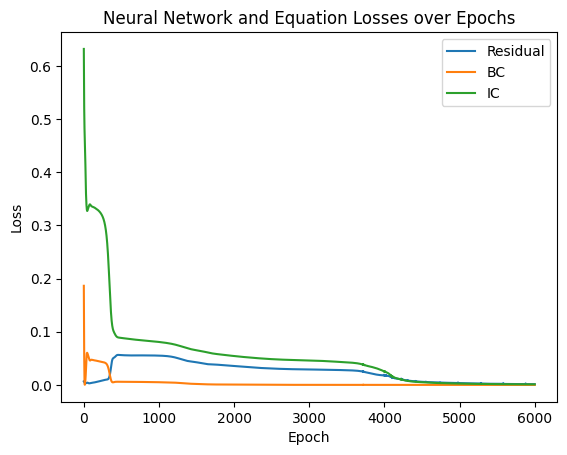

In [ ]:
plot_loss(losses)

In [ ]:
%matplotlib inline

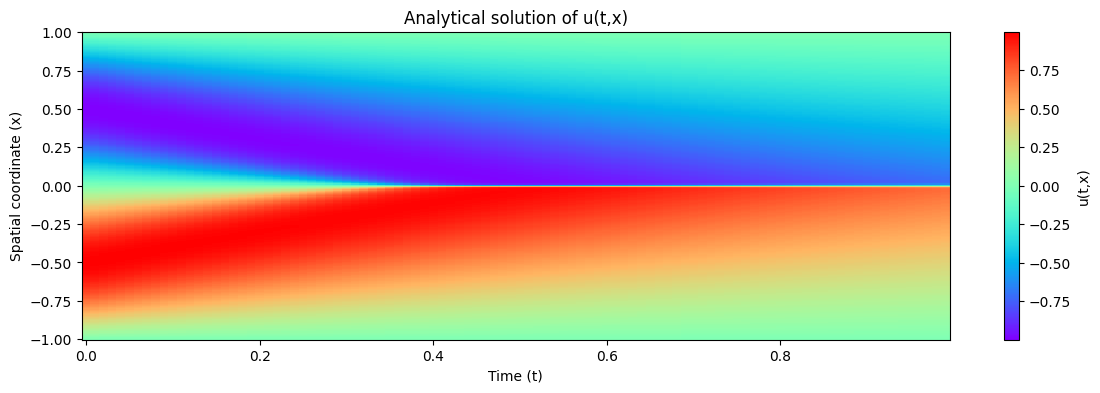

In [ ]:
fig = plt.figure(figsize=(14, 4))
plt.pcolormesh(T, X, Exact, shading='auto',cmap='rainbow')
plt.colorbar(label='u(t,x)')
plt.xlabel('Time (t)')
plt.ylabel('Spatial coordinate (x)')
plt.title('Analytical solution of u(t,x)')
plt.show()


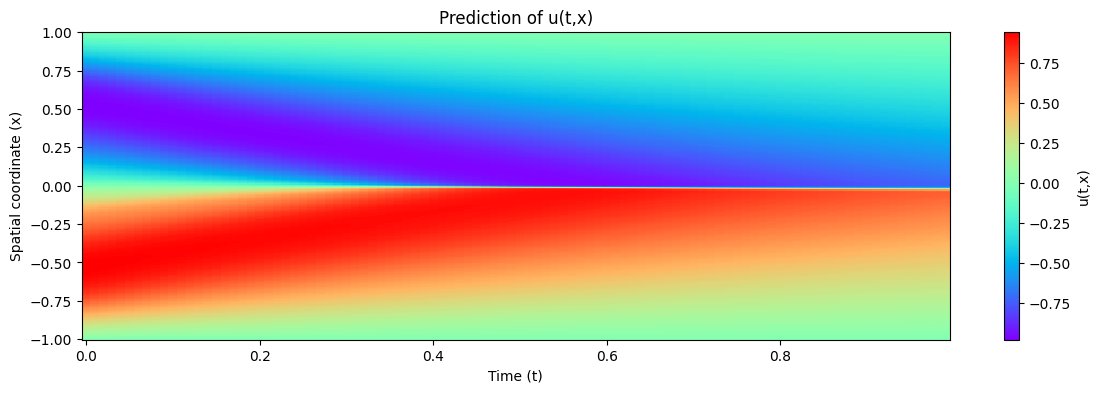

In [ ]:
X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None] ))

X_star_ten=torch.tensor(X_star)


with torch.no_grad():  # No need to track gradients here
  u_pred = model(X_star_ten.double().to(device)).cpu().numpy()


U_pred = griddata(X_star, u_pred.flatten(), (T, X), method='cubic')
fig = plt.figure(figsize=(14, 4))
plt.pcolormesh(T, X, U_pred, shading='auto',cmap='rainbow')
plt.colorbar(label='u(t,x)')
plt.xlabel('Time (t)')
plt.ylabel('Spatial coordinate (x)')
plt.title('Prediction of u(t,x)')
plt.show()


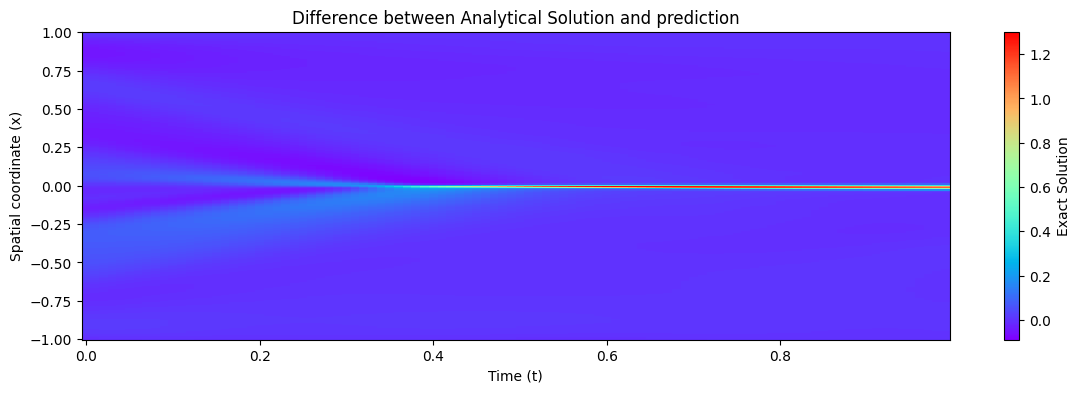

In [ ]:

X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None] ))

X_star_ten=torch.tensor(X_star)


with torch.no_grad():  # No need to track gradients here
  u_pred = model(X_star_ten.double().to(device)).cpu().numpy()


U_pred = griddata(X_star, u_pred.flatten(), (T, X), method='cubic')
fig = plt.figure(figsize=(14, 4))
plt.pcolormesh(T, X, Exact-U_pred, shading='auto',cmap='rainbow')
plt.colorbar(label='Exact Solution')
plt.xlabel('Time (t)')
plt.ylabel('Spatial coordinate (x)')
plt.title('Difference between Analytical Solution and prediction')
plt.show()


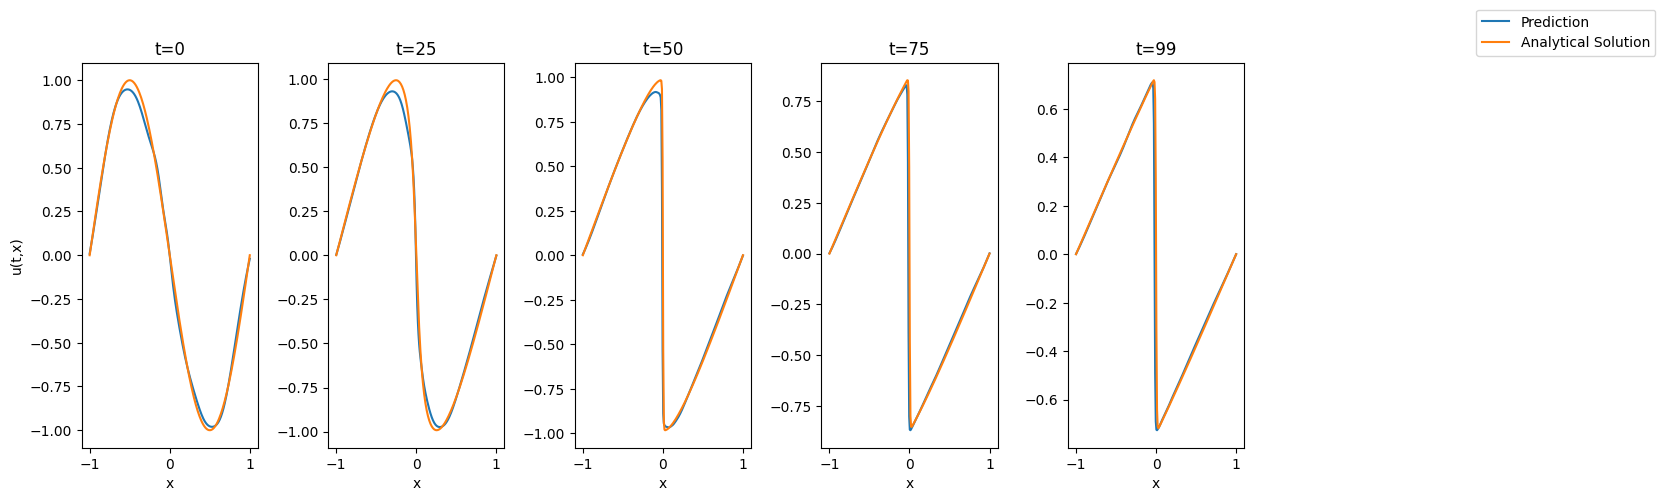

In [ ]:
x_span = np.linspace(-1, 1, 100)
# Your provided data and setup
t_cross_sections = [0, 25, 50, 75, 99]
fig, axs = plt.subplots(1, len(t_cross_sections), figsize=(15, 5))  # Adjust figsize as needed

# Assuming 'model', 't_span', 'x_span', and 'device' are defined

for i, t_cs in enumerate(t_cross_sections):
    axs[i].set_title('t={}'.format(t_cs))
    axs[i].set_xlabel('x')
    if i == 0:
        axs[i].set_ylabel('u(t,x)')
    # Plotting the predictions and analytical solutions
    axs[i].plot(x, U_pred[t_cs,:], label='Prediction')
    axs[i].plot(x, Exact[t_cs,:], label='Analytical Solution')

# Adjust the layout
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

# Add a legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()


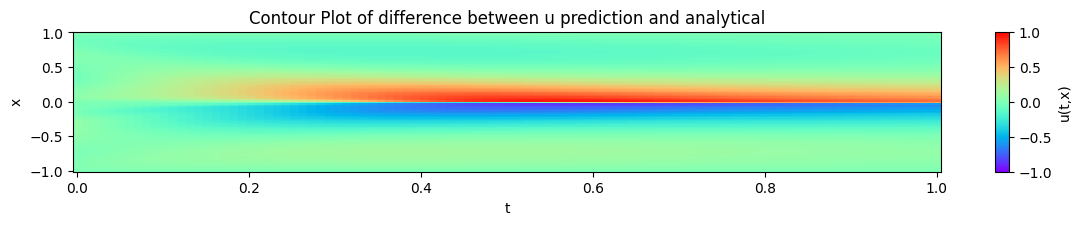

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define the analytical solution
def analytical_solution(t, x):
    return np.exp(-t) * np.sin(-np.pi * x)

#def analytical_solution(t, x):
#    return -2 * v* np.pi*(np.cos(np.pi*x)/np.sin(np.pi *x))

# Create a meshgrid in the 2D plane
N = 100  # Define the resolution of the grid
t_span = np.linspace(0, 1, N)
x_span = np.linspace(-1, 1, N)
t, x = np.meshgrid(t_span, x_span)

# Compute the analytical solution on the meshgrid
u_analytical = analytical_solution(t, x)
t_flat = t.flatten()
x_flat = x.flatten()

# Combine into a single 2-column array with t and x as the columns
t_x = np.stack((t_flat, x_flat), axis=-1)

# Convert to PyTorch tensor and make predictions
t_x_tensor = torch.tensor(t_x, dtype=torch.float32)
with torch.no_grad():  # No need to track gradients here
  u = model(t_x_tensor.double().to(device)).cpu().numpy()

difference=u_analytical-u.reshape(t.shape)

# Plotting
fig = plt.figure(figsize=(14, 4))
gs = GridSpec(2, 6)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, difference, cmap='rainbow')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Contour Plot of difference between u prediction and analytical')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
plt.show()

